In [1]:
import pymongo
import math 
# import re
import pandas as pd
# import numpy as np
import pylab 
from matplotlib import pyplot as plt
# from scipy import stats 
from  qgrid import show_grid as show 
from datetime import datetime
from powerapi.formula import RAPLFormulaHWPCReportHandler, FormulaState
from powerapi.report import HWPCReport
import seaborn as sns
class testCase(object): 
    """in general its just the name of the machine where we launched the test """
    def __init__ (self , testname,database='rapls2',serveraddr='172.16.45.8',serverport=27017): 
        self._client = pymongo.MongoClient(serveraddr, serverport)
        self._db=self._client[database]
        self._testname=testname 
        self._sensors=self._db['sensor'+self._testname]
        self._formula_id = (None,)
        self._state = FormulaState(None, None, None, self._formula_id)
        self._handler = RAPLFormulaHWPCReportHandler(None)
        
    def gettimetamps(self,containername): 
        containerdata=list(self._sensors.find({'target':containername},projection=['timestamp']))
        begintime= containerdata[0]['timestamp']
        endtime=containerdata[-1]['timestamp']
        return begintime , endtime 

    def _process_power(self,row,socket,event):
        hwpc_report = HWPCReport.deserialize(row)
        for i in self._handler._process_report(hwpc_report, self._state) : 
            if i.metadata['socket']== socket and i.metadata['event']==event : 
                return i.power
        return -1 
    
    def _get_headers(self,row):
        hwpc_report = HWPCReport.deserialize(row)
        x=self._handler._process_report(hwpc_report,self._state)
        return [(i.metadata['socket'],i.metadata['event']) for i in x ]
    
    
    def getpowers(self,containername): 
        #get the power consumption of the system  between begin and end 
        begin , end = self.gettimetamps(containername) 
        x=list(self._sensors.find({'target':'all','timestamp' :{'$gte':begin,'$lte':end}}))
        conso= pd.DataFrame(x)

        headers=self._get_headers(x[0])
        for i in headers: 
            socket,event=i 
            title="powers_{}_{}".format(event.split('_')[-1],socket)
            conso[title]=conso.T.apply(lambda row: self._process_power(row,socket,event))

        return conso.drop(["_id","groups","sensor","target"],axis=1)
        
    def getpowersFromInterval(self,begin,end): 
        #get the power consumption of the system  between begin and end 
#         begin , end = self.gettimetamps(containername) 
        x=list(self._sensors.find({'target':'all','timestamp' :{'$gte':begin,'$lte':end}})) 
        conso= pd.DataFrame(x)

        headers=self._get_headers(x[0])
        for i in headers: 
            socket,event=i 
            title="powers_{}_{}".format(event.split('_')[-1],socket)
            conso[title]=conso.T.apply(lambda row: self._process_power(row,socket,event))

        return conso.drop(["_id","groups","sensor","target"],axis=1)
   
    def getenergy(self,containername):
        powers =self.getpowers(containername)
        powers=powers.loc[:,[ i for i in powers.columns if 'powers_' in i ]]
        return powers.sum()    
    
    def getenergyfromInterval(self,begin,end):
        powers =self.getpowersFromInterval(begin,end)
        powers=powers.loc[:,[ i for i in powers.columns if 'powers_' in i ]]
        return powers.sum()
   
    def getrecap(self): 
        meausres = self._db['recap'+self._testname].find(projection={'_id': False,'id':False,'beginwarmup':False,'beginexecution':False})
        return pd.DataFrame(list(meausres))
    
def normalize(self):
    df=self
    return (df - df.mean()) / (df.max() - df.min())

pd.DataFrame.normalize = normalize

In [2]:
machine = testCase("testcore280319")
def gettime(s): 
    format = '%Y-%m-%d %H:%M:%S'
    return datetime.strptime(s, format)


In [3]:
#to print the energy of a docker container named  tommti_python3_intArithmetic_50_0
recap=machine.getrecap()
# machine._db['recap'+machine._testname].drop()
recap

,begin,end,execution time,execution_powers_CORES_0,execution_powers_CORES_1,execution_powers_DRAM_0,execution_powers_DRAM_1,execution_powers_PKG_0,execution_powers_PKG_1,name,warmup time
0,2019-03-28 13:57:10,2019-03-28 13:59:12,122.0,4872.374786,5229.607513,816.167953,1082.946320,6422.940231,6783.215530,testdocker_1,0.0
1,2019-03-28 13:59:12,2019-03-28 14:01:12,120.0,5059.114548,5413.183685,793.127472,1060.462982,6593.619064,6943.498840,testbinarry_1,0.0
2,2019-03-28 14:01:13,2019-03-28 14:03:14,121.0,4838.368683,5260.702896,819.251404,1084.216064,6388.878510,6806.798355,testdocker_2,0.0
3,2019-03-28 14:03:15,2019-03-28 14:05:15,120.0,5040.715515,5486.679779,818.893066,1076.095810,6581.188995,7021.621582,testbinarry_2,0.0
4,2019-03-28 14:05:15,2019-03-28 14:07:17,122.0,4938.051834,5275.074173,840.044479,1077.234909,6505.718750,6837.209686,testdocker_3,0.0
5,2019-03-28 14:07:17,2019-03-28 14:09:17,120.0,5070.805862,5419.753845,807.196838,1054.790863,6611.014572,6953.802155,testbinarry_3,0.0
6,2019-03-28 14:09:18,2019-03-28 14:11:19,121.0,4885.299164,5239.956833,802.795334,1067.510834,6438.245605,6787.536331,testdocker_4,0.0
7,2019-03-28 14:11:20,2019-03-28 14:13:20,120.0,5047.391006,5489.354736,812.437820,1087.675400,6589.796677,7026.437180,testbinarry_4,0.0
8,2019-03-28 14:13:20,2019-03-28 14:15:22,122.0,4932.207565,5266.439423,825.049194,1107.143570,6496.149048,6823.759811,testdocker_5,0.0
9,2019-03-28 14:15:22,2019-03-28 14:17:22,120.0,5050.750015,5490.792191,811.652405,1088.029892,6595.500015,7028.876678,testbinarry_5,0.0


binary 1
docker 2


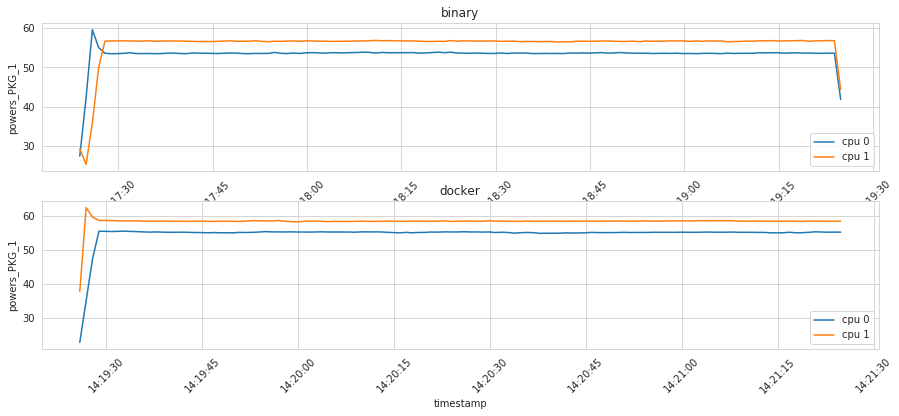

In [105]:
%matplotlib inline 
sns.set_style('whitegrid')

class Recap(object): 
    
    def __init__(self,machinename,Nrows=1,titles=["binary","docker"]):
        self.machine= machinename 
        self.Nrows=Nrows
        self.titles=titles
        self.totalFigures= len(self.titles)
        self.fig = plt.figure(figsize=(15, 6))
        self.fig.subplots_adjust(hspace=0.2, wspace=0.4)
        
    def getrecap(self,n): 
        return self.machine.getpowersFromInterval(self.machine.getrecap().iloc[n].begin,self.machine.getrecap().iloc[n].end)

    def get(self,testnumber):         
        self.res={}
        for i in range(self.totalFigures): 
            self.res[titles[i]]= self.getrecap(testnumber+i)
        return self.res
    
    def plot(self,testnumber):
        self.get(testnumber)
        j=1
        for i in self.res.keys() : 
            print (i,j)
            ax=self.fig.add_subplot(self.Nrows, math.ceil(self.totalFigures/self.Nrows),j)
            plt.xticks(rotation=45)
            sns.lineplot(x='timestamp',y="powers_PKG_0",data=self.res[i],label='cpu 0',axes=ax )
            
            sns.lineplot(x='timestamp',y="powers_PKG_1",data=self.res[i],label='cpu 1',axes=ax).set_title(i)
            j+=1
#             return 
            
x=Recap(machine,2)
x.plot(10)

In [8]:
recap1=recap.loc[recap.name.str.contains('.*_2_.*')]
recap1["source"]=recap.name.apply(lambda name:  name.split("_")[0].replace('test',''))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


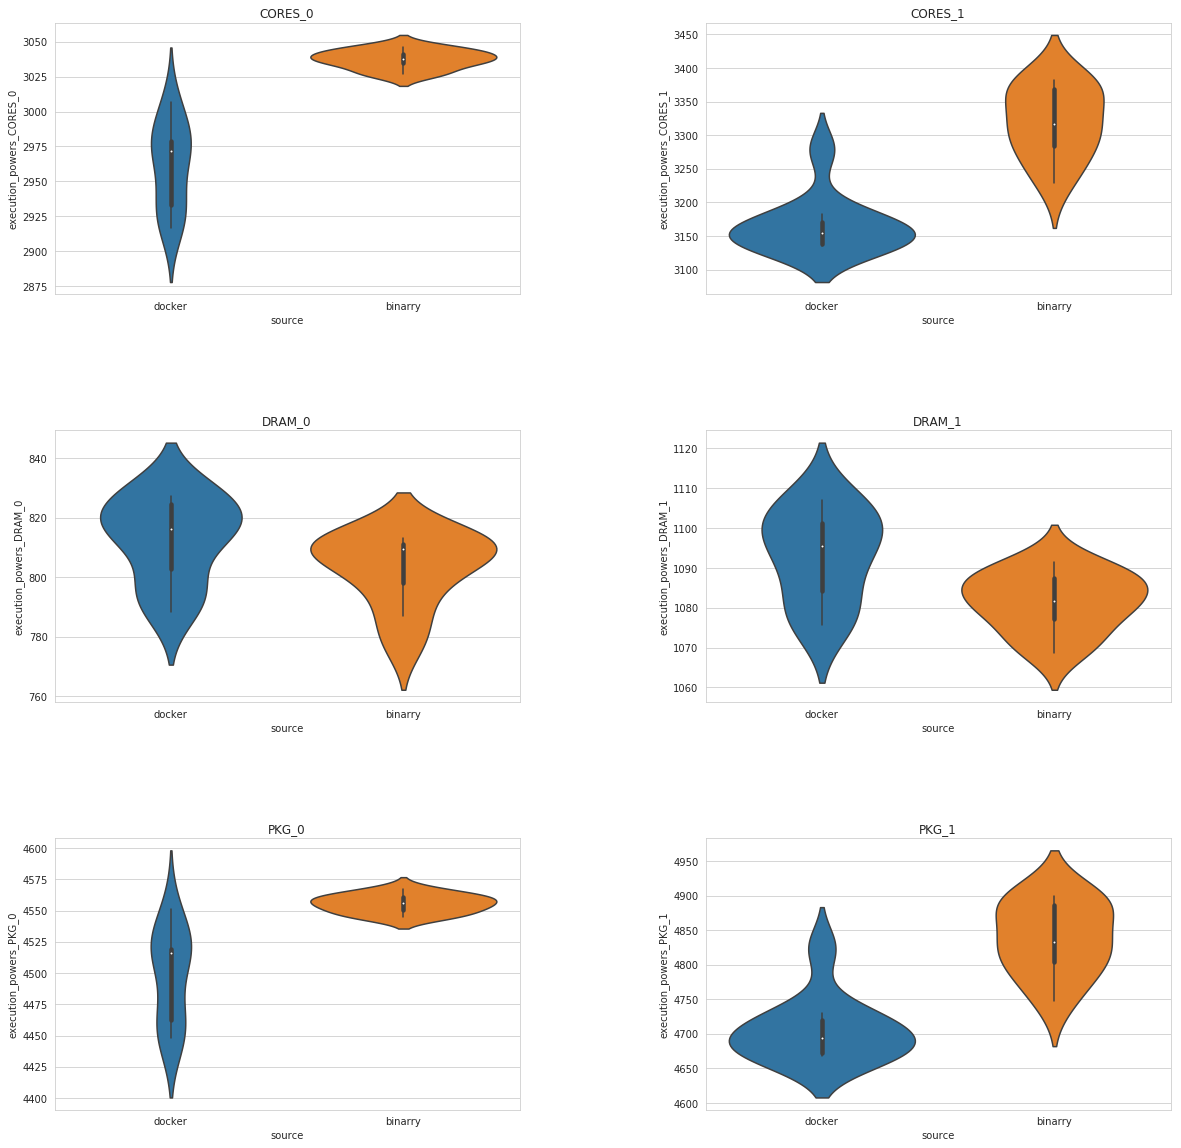

In [20]:
%matplotlib inline 
sns.set_style('whitegrid')

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.5, wspace=0.4)
j=1
for i in recap1.columns: 
    if 'execution_powers' in i : 
        ax=fig.add_subplot(3,2,j)
        sns.violinplot(data=recap1,y=i,x="source",axes=ax).set_title(i.replace('execution_powers_',''))
        j+=1

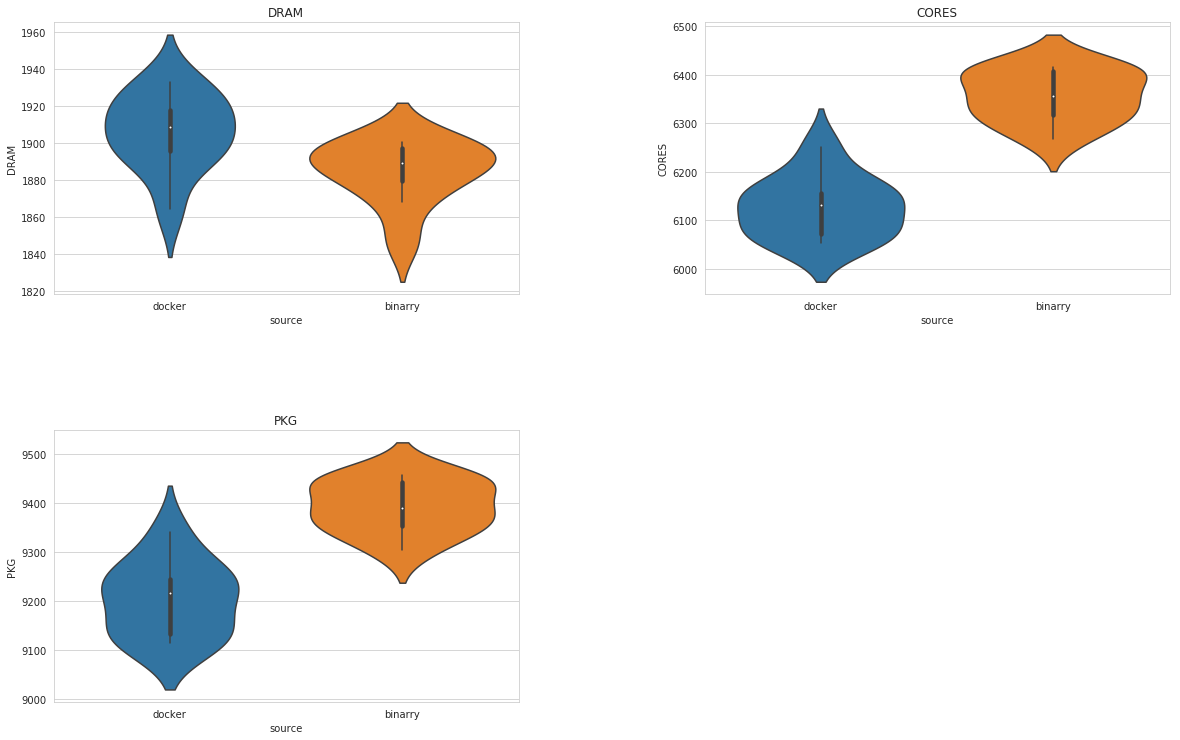

In [21]:
recap2= recap1.loc[:,['name','source']+[i for i in recap1.columns if 'execution_powers' in i ]]
recap2.columns = [i.replace('execution_powers_','')for i in recap2.columns]
for i in range(1,4): 
    colname=recap2.columns[i+i][:-2]
    recap2[colname]=recap2[colname+'_0']+recap2[colname+'_1']
recaptotal=recap2.loc[:,[i for i in recap2.columns if  not( '_' in i) ]]
l=['DRAM','CORES','PKG']

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0.5, wspace=0.4)
j=1
for i in l:  
    ax=fig.add_subplot(3,2,j)
    sns.violinplot(data=recaptotal,y=i,x="source",axes=ax).set_title(i)
    j+=1

In [15]:
docker=recap1.loc[recap1.source=='docker',[i for i in recap1.columns if 'execution_powers' in i ]]
docker.columns = [i.replace('execution_powers_','')for i in docker.columns]
docker.normalize().describe()

,CORES_0,CORES_1,DRAM_0,DRAM_1,PKG_0,PKG_1
count,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01
mean,2.775558e-18,-1.110223e-17,1.176836e-15,-2.897682e-15,3.524958e-15,2.320366e-15
std,3.423558e-01,3.005509e-01,3.635395e-01,3.639863e-01,3.624808e-01,3.015040e-01
min,-4.926995e-01,-2.131062e-01,-6.265904e-01,-5.563293e-01,-4.865563e-01,-2.483736e-01
25%,-3.137815e-01,-1.961359e-01,-2.620161e-01,-2.843850e-01,-3.450783e-01,-2.174714e-01
50%,1.182154e-01,-7.991279e-02,8.378151e-02,7.599535e-02,1.769574e-01,-7.850705e-02
75%,1.956997e-01,3.577264e-02,3.042813e-01,2.569156e-01,2.033235e-01,8.412112e-02
max,5.073005e-01,7.868938e-01,3.734096e-01,4.436707e-01,5.134437e-01,7.516264e-01


In [16]:
pd.options.display.float_format = '{:.3f}'.format
binarry=recap1.loc[recap1.source=='binarry',[i for i in recap1.columns if 'execution_powers' in i ]]
binarry.columns = [i.replace('execution_powers_','')for i in binarry.columns]
binarry.normalize().describe()

,CORES_0,CORES_1,DRAM_0,DRAM_1,PKG_0,PKG_1
count,10.000,10.000,10.000,10.000,10.000,10.000
mean,-0.000,-0.000,-0.000,0.000,0.000,0.000
std,0.343,0.343,0.342,0.321,0.334,0.343
min,-0.539,-0.591,-0.711,-0.561,-0.470,-0.596
25%,-0.146,-0.228,-0.134,-0.186,-0.213,-0.229
50%,0.019,-0.024,0.189,0.003,0.008,-0.033
75%,0.214,0.320,0.232,0.261,0.232,0.320
max,0.461,0.409,0.289,0.439,0.530,0.404


In [17]:
for i in range(0,3): 
    colname=docker.columns[i+i][:-2]
    docker[colname]=docker[colname+'_0']+docker[colname+'_1']
for i in range(0,3): 
    colname=binarry.columns[i+i][:-2]
    binarry[colname]=binarry[colname+'_0']+binarry[colname+'_1']

In [18]:
docker.describe()

,CORES_0,CORES_1,DRAM_0,DRAM_1,PKG_0,PKG_1,CORES,DRAM,PKG
count,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000
mean,2961.221,3166.206,812.851,1093.083,4497.964,4706.367,6127.427,1905.934,9204.331
std,30.881,43.060,14.169,11.431,37.468,47.100,62.594,20.443,75.183
min,2916.779,3135.674,788.429,1075.612,4447.671,4667.567,6052.454,1864.041,9115.238
25%,2932.918,3138.106,802.638,1084.152,4462.295,4672.394,6072.425,1895.757,9134.177
50%,2971.884,3154.757,816.116,1095.470,4516.255,4694.103,6130.649,1908.281,9216.854
75%,2978.873,3171.331,824.710,1101.152,4518.980,4719.508,6156.276,1917.544,9244.988
max,3006.980,3278.943,827.405,1107.016,4551.036,4823.785,6251.498,1932.596,9341.247


In [19]:
binarry.describe()

,CORES_0,CORES_1,DRAM_0,DRAM_1,PKG_0,PKG_1,CORES,DRAM,PKG
count,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000
mean,3037.449,3319.646,802.839,1081.514,4555.603,4838.321,6357.096,1884.353,9393.925
std,6.714,52.821,12.199,7.342,7.464,52.031,52.732,16.882,52.495
min,3026.908,3228.618,777.478,1068.682,4545.097,4747.940,6267.908,1846.160,9304.354
25%,3034.594,3284.481,798.069,1077.253,4550.837,4803.510,6317.017,1879.045,9354.010
50%,3037.814,3316.028,809.565,1081.590,4555.775,4833.318,6356.902,1889.083,9391.310
75%,3041.637,3368.992,811.120,1087.477,4560.777,4886.901,6408.062,1896.984,9442.786
max,3046.464,3382.600,813.128,1091.565,4567.427,4899.624,6416.270,1900.285,9458.232
